DataFrame shape: (1534, 13)


/var/folders/00/nl39rjy54_j8lt07mj00bb9c0000gn/T/ipykernel_16051/2917027192.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['PriceAfterTaxCredit'].fillna(df['Price'], inplace=True)
/var/folders/00/nl39rjy54_j8lt07mj00bb9c0000gn/T/ipykernel_16051/2917027192.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([

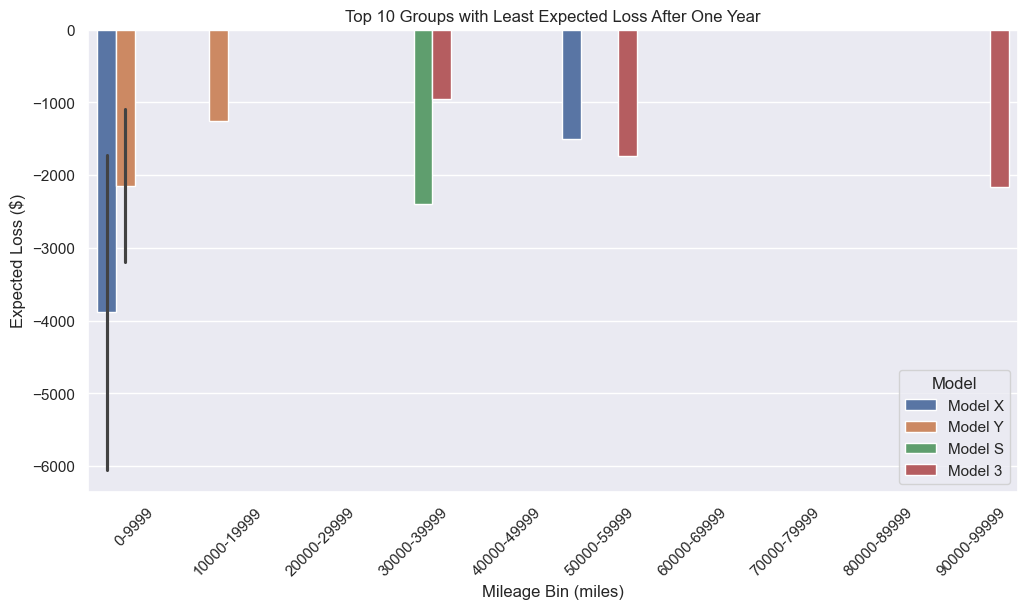

In [13]:
# Import necessary libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting
%matplotlib inline
sns.set()

# Connect to the SQLite database
conn = sqlite3.connect('../data/tesla_inventory.db')

# Load data into a DataFrame
df = pd.read_sql_query("SELECT * FROM inventory", conn)

# Close the connection
conn.close()

# Display the first few rows
df.head()

# Check the shape of the DataFrame
print(f"DataFrame shape: {df.shape}")

# Fill missing PriceAfterTaxCredit with Price
df['PriceAfterTaxCredit'].fillna(df['Price'], inplace=True)

# Ensure the column is numeric
df['PriceAfterTaxCredit'] = df['PriceAfterTaxCredit'].astype(float)

df['Year'] = df['Year'].astype(int)
df['Price'] = df['Price'].astype(float)
df['Mileage'] = df['Mileage'].astype(int)
df['CleanHistory'] = df['CleanHistory'].astype(bool)
df['FSD'] = df['FSD'].astype(bool)

# Define mileage bin edges (every 10,000 miles)
bin_edges = range(0, df['Mileage'].max() + 10000, 10000)

# Create labels for the bins
bin_labels = [f"{bin_edges[i]}-{bin_edges[i+1]-1}" for i in range(len(bin_edges)-1)]

# Categorize mileage into bins
df['MileageBin'] = pd.cut(df['Mileage'], bins=bin_edges, labels=bin_labels, right=False)

# Display the distribution of cars across mileage bins
df['MileageBin'].value_counts().sort_index()

grouped = df.groupby(['Model', 'Trim', 'Year', 'FSD', 'MileageBin'])

# Aggregate data
grouped_df = grouped.agg({
    'Price': 'mean',
    'PriceAfterTaxCredit': 'mean',
    'Mileage': 'mean',
    'CleanHistory': 'mean',  # Percentage of cars with clean history
    'ExteriorColor': lambda x: x.mode()[0],  # Most common color
    'Wheels': lambda x: x.mode()[0],         # Most common wheels
    'Interior': lambda x: x.mode()[0],       # Most common interior
    'VIN': 'count'  # Number of cars in the group
}).rename(columns={'VIN': 'Count'})

# Reset index to turn grouped columns into regular columns
grouped_df = grouped_df.reset_index()

# Display the grouped DataFrame
grouped_df.head()

def estimate_group_depreciation(row, annual_mileage=10000):
    """
    Estimates the depreciation of a group of cars after one year.
    
    Parameters:
        row (pd.Series): A row from the grouped DataFrame.
        annual_mileage (int): Miles added in one year.
        
    Returns:
        float: Estimated value after one year for the group.
    """
    # Current attributes
    current_price = row['Price']
    current_mileage = row['Mileage']
    model = row['Model']
    trim = row['Trim']
    year = row['Year']
    fsd = row['FSD']
    
    # Future attributes
    future_mileage = current_mileage + annual_mileage
    # Determine the future mileage bin
    future_mileage_bin = pd.cut([future_mileage], bins=bin_edges, labels=bin_labels, right=False)[0]
    
    # Filter groups with future mileage bin
    future_group = grouped_df[
        (grouped_df['Model'] == model) &
        (grouped_df['Trim'] == trim) &
        (grouped_df['Year'] == year) &
        (grouped_df['FSD'] == fsd) &
        (grouped_df['MileageBin'] == future_mileage_bin)
    ]
    
    if not future_group.empty:
        # Use the average price of the future group as the estimated value
        estimated_price = future_group.iloc[0]['Price']
    else:
        # If no future group, estimate depreciation using a standard rate
        # Assume a depreciation rate of 10% per 10,000 miles
        depreciation_rate = 0.10
        estimated_price = current_price * (1 - depreciation_rate)
    
    return estimated_price

# Estimate resale value after one year for each group
grouped_df['EstimatedValueAfter1Year'] = grouped_df.apply(estimate_group_depreciation, axis=1)

# Calculate the expected loss for each group
grouped_df['ExpectedLoss'] = grouped_df['PriceAfterTaxCredit'] - grouped_df['EstimatedValueAfter1Year']

# Sort the DataFrame by ExpectedLoss
grouped_df_sorted = grouped_df.sort_values(by='ExpectedLoss')

# Display the sorted DataFrame
grouped_df_sorted.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=grouped_df_sorted.head(10),
    x='MileageBin',
    y='ExpectedLoss',
    hue='Model'
)
plt.title('Top 10 Groups with Least Expected Loss After One Year')
plt.ylabel('Expected Loss ($)')
plt.xlabel('Mileage Bin (miles)')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.show()
